In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import norm
import copy
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
class GaussianBandit:
    def __init__(self, K: int, N: int, mu):
        self.K = K # number of possible actions
        self.N = N # number of steps
        self.mu = mu
        self.mu_sampled = np.zeros(K)
        self.precision = np.ones(K)
        self.chosen_actions = []

    # try k-th action
    def play(self, action):
        return np.random.normal(self.mu[action], 1)

    # update sampled parameters
    def update(self, action, reward):
        self.mu_sampled[action] = (self.mu_sampled[action] * self.precision[action] + reward)/(self.precision[action] + 1)
        self.precision[action] += 1

    # per-period regret (in one simulation)
    def per_period_regret(self):
        regret = []
        for i in range(self.N):
            regret.append(np.max(self.mu) - self.mu[self.chosen_actions[i]])
        return regret

    def run_simulation(self):
        pass

    def get_name(self):
        pass

In [3]:
class EpsilonGreedy(GaussianBandit):
    def __init__(self, K: int, N: int, mu, epsilon: float):
        super(EpsilonGreedy, self).__init__(K, N, mu)
        self.epsilon = epsilon
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            if np.random.random() < self.epsilon:
                self.chosen_actions.append(np.random.randint(0, self.K))
            else:
                theta_sampled = self.mu_sampled
                self.chosen_actions.append(np.random.choice([i for i in range(self.K) if theta_sampled[i] == np.max(theta_sampled)]))

            reward = self.play(self.chosen_actions[-1])

            self.update(self.chosen_actions[-1], reward)

    def get_name(self):
        if self.epsilon == 0:
            return 'Greedy'
        else:
            return f'{self.epsilon}-Greedy'

In [4]:
class AnnealingEpsilonGreedy(GaussianBandit):
    def __init__(self, K: int, N: int, mu, m: float):
        super(AnnealingEpsilonGreedy, self).__init__(K, N, mu)
        self.m = m
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            if np.random.random() < self.m/(self.m + t):
                self.chosen_actions.append(np.random.randint(0, self.K))
            else:
                theta_sampled = self.mu_sampled
                self.chosen_actions.append(np.random.choice([i for i in range(self.K) if theta_sampled[i] == np.max(theta_sampled)]))

            reward = self.play(self.chosen_actions[-1])

            self.update(self.chosen_actions[-1], reward)

    def get_name(self):
            return f'{self.m}/({self.m}+t)-Greedy'

In [5]:
class ThompsonSampling(GaussianBandit):
    def __init__(self, K: int, N: int, mu, save_params_statistics: bool=False):
        super(ThompsonSampling, self).__init__(K, N, mu)
        if save_params_statistics:
            self.params_statistic = []
        else:
            self.params_statistic = None
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            theta_sampled = []
            for k in range(self.K):
                theta_sampled.append(np.random.normal(self.mu_sampled[k], 1/self.precision[k]))
            self.chosen_actions.append(np.argmax(theta_sampled))

            reward = self.play(self.chosen_actions[-1])

            self.update(self.chosen_actions[-1], reward)
            if self.params_statistic is not None and t+1 in [1, 2, 5, 15, 25, 50, 100, 200, 1000]:
                self.params_statistic.append((copy.copy(self.mu_sampled), copy.copy(self.precision)))

    def get_name(self):
        return 'Thompson Sampling'

    def plot_beta_distributions(self):
        iteration_list = [1, 2, 5, 15, 25, 50, 100, 200, 1000]
        fig, axs = plt.subplots(3, 3)

        for i in range(9):
            plt.subplot(3, 3, i+1)
            x = np.linspace(-1.0, 1.0, 1000)
            for k in range(self.K):
                y = norm.pdf(x, self.params_statistic[i][0][k], 1/(self.params_statistic[i][1][k]+1))
                axs[i//3, i%3].plot(x, y, label=f"{round(self.params_statistic[i][0][k], 2)}/{int(self.params_statistic[i][1][k])}")
            axs[i//3, i%3].set_xlabel(f"{iteration_list[i]} iterations")
            axs[i//3, i%3].legend()

        plt.show()


In [6]:
class SimulationCollection:
    def __init__(self, K: int, N: int, num_simulations: int):
        self.K = K #number of possible actions
        self.N = N #number of steps
        self.num_simulations = num_simulations
        self.mu = self.create_bandit()
        self.simulations = {}

    #create K-handed Bernoulli bandit
    def create_bandit(self):
        return np.random.normal(0, 1, (self.num_simulations, self.K))

    def create_epsilon_greedy(self, epsilon):
        self.simulations[f'EG_{epsilon}'] = []
        for i in range(self.num_simulations):
            epsilon_greedy = EpsilonGreedy(self.K, self.N, self.mu[i], epsilon)
            self.simulations[f'EG_{epsilon}'].append(epsilon_greedy)
            print(f"Finished epsilon_greedy experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of epsilon greedy                                                        ")


    def create_annealing_epsilon_greedy(self, m):
        self.simulations[f'AEG_{m}'] = []
        for i in range(self.num_simulations):
            annealing_epsilon_greedy = AnnealingEpsilonGreedy(self.K, self.N, self.mu[i], m)
            self.simulations[f'AEG_{m}'].append(annealing_epsilon_greedy)
            print(f"Finished annealing_epsilon_greedy experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of annealing epsilon greedy                                                        ")

    def create_thompson_sampling(self):
        self.simulations['TS'] = []
        for i in range(self.num_simulations):
            thompson_sampling = ThompsonSampling(self.K, self.N, self.mu[i])
            self.simulations['TS'].append(thompson_sampling)
            print(f"Finished thompson sampling experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of thompson sampling                                                        ")

    def print_statistics_table(self):
        if self.num_simulations == 1:
            data = [
                ['Actions:'] + list(range(self.K)),
                ['Mean reward:'] + list(np.around(self.mu[0], decimals=3))
            ]
            for sim in self.simulations.values():
                data.append([sim[0].get_name()] + [sim[0].chosen_actions.count(i) for i in range(self.K)])
            print(tabulate(data, tablefmt="fancy_grid", numalign="right"))
        else:
            print('Can only print statistics table only if num_simulations==1')

    #plot per-period regret (average over many simulations)
    def plot_mean_per_period_regret(self):
        fig, ax = plt.subplots()

        for sim in self.simulations.values():
            ax.plot(range(self.N), np.mean([sim[i].per_period_regret() for i in range(self.num_simulations)], axis=0), label=sim[0].get_name())

        ax.legend()
        ax.set_title(f'mean per-period regret over {self.num_simulations} simulations')
        ax.set_xlabel('time period')
        ax.set_ylabel(None)

        plt.show()

In [7]:
%%time

simulations = SimulationCollection(K=10, N=500, num_simulations=1)
simulations.create_epsilon_greedy(0)
simulations.create_epsilon_greedy(0.05)
simulations.create_annealing_epsilon_greedy(9)
simulations.create_thompson_sampling()

simulations.print_statistics_table()

Finished simulation of epsilon greedy                                                        
Finished simulation of epsilon greedy                                                        
Finished simulation of annealing epsilon greedy                                                        
Finished simulation of thompson sampling                                                        
╒═══════════════════╤═══════╤═══════╤════════╤═══════╤══════╤═══════╤════════╤════════╤════════╤════════╕
│ Actions:          │     0 │     1 │      2 │     3 │    4 │     5 │      6 │      7 │      8 │      9 │
├───────────────────┼───────┼───────┼────────┼───────┼──────┼───────┼────────┼────────┼────────┼────────┤
│ Mean reward:      │ 1.306 │ 0.912 │ -0.965 │ 0.574 │ 0.12 │ 0.182 │ -1.282 │ -0.136 │ -0.103 │ -2.348 │
├───────────────────┼───────┼───────┼────────┼───────┼──────┼───────┼────────┼────────┼────────┼────────┤
│ Greedy            │     0 │   493 │      2 │     0 │    1 │     1 │      0 │   

Finished simulation of epsilon greedy                                                        
Finished simulation of epsilon greedy                                                        
Finished simulation of annealing epsilon greedy                                                        
Finished simulation of thompson sampling                                                        


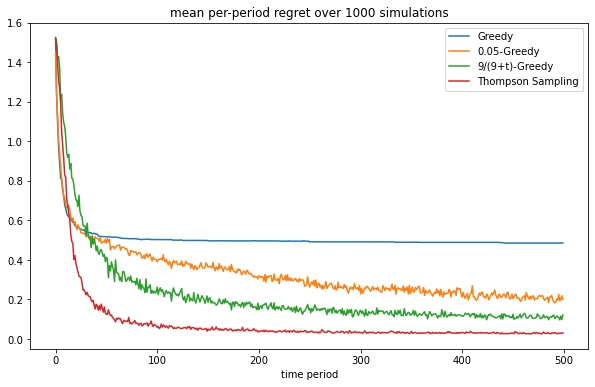

CPU times: total: 1min 19s
Wall time: 1min 17s


In [8]:
%%time

simulations = SimulationCollection(K=10, N=500, num_simulations=1000)

simulations.create_epsilon_greedy(0)
simulations.create_epsilon_greedy(0.05)
simulations.create_annealing_epsilon_greedy(9)
simulations.create_thompson_sampling()

simulations.plot_mean_per_period_regret()

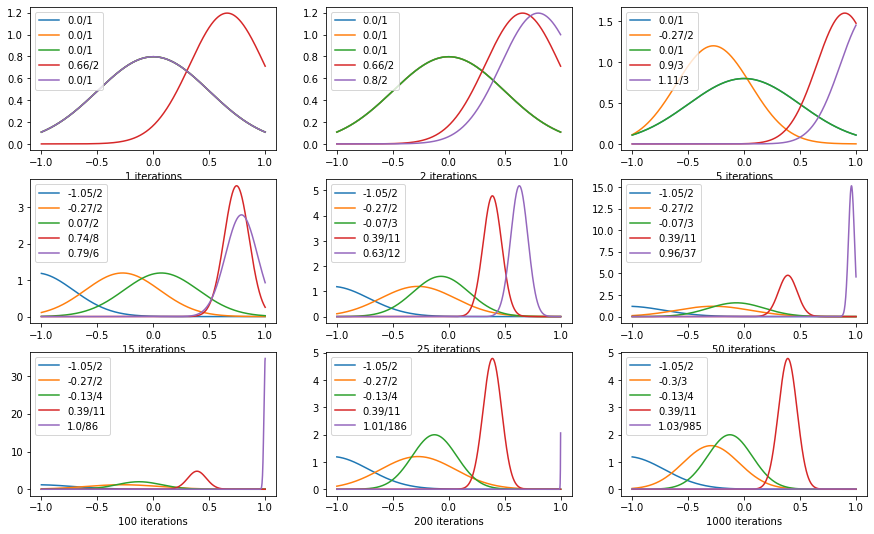

In [9]:
plt.rcParams['figure.figsize'] = [15, 9]

TS = ThompsonSampling(K=5, N=1000, mu=[-1.0, -0.5, 0.0, 0.5, 1.0], save_params_statistics=True)

TS.plot_beta_distributions()